In [1]:
import numpy as np
# import scipy
from scipy.ndimage import gaussian_filter1d as g_filter
# from astropy import units as u
import matplotlib.pyplot as plt
# import pandas as pd
from tools.file_finder import find_file

In [9]:
date = "210513"
date2 = "210611"

odmr_paths = [
    # find_file("ODMR", 1, date, contains="Counts"),
    # find_file("ODMR", 2, date, contains="Counts"),
    # find_file("ODMR", 5, date, contains="Counts"), 
    # find_file("ODMR", 6, date, contains="Counts"),
    # find_file("ODMR", 7, date, contains="Counts"), 
    # find_file("ODMR", 8, date, contains="Counts"), 
    # find_file("ODMR", 9, date, contains="Counts"),
    find_file("ODMR", 3, date2, contains="Counts"),
    find_file("ODMR", 7, date2, contains="Counts"),
]
odmr_specs = [
    np.genfromtxt(f) for f in odmr_paths
]

num_not_final = len(odmr_specs)
swp_spcs = slice(0, num_not_final) # Later we will want to only fetch specs from this original list

freq_axes = [spec[0] for spec in odmr_specs]
odmr_specs = [spec[1:] for spec in odmr_specs]

final_paths = []
    # "ODMR_3_2peaks.txt", #"ODMR_4_same_as_3.txt"
# ]
final_specs = [
    np.genfromtxt(f, skip_header=18).T for f in final_paths
]
freq_axes += [spec[0] for spec in final_specs]
odmr_specs += [spec[1].reshape(1,-1) for spec in final_specs]
odmr_paths += final_paths

# odmr_specs[-2].shape

Caching...Done.

## Plot Counts for each:

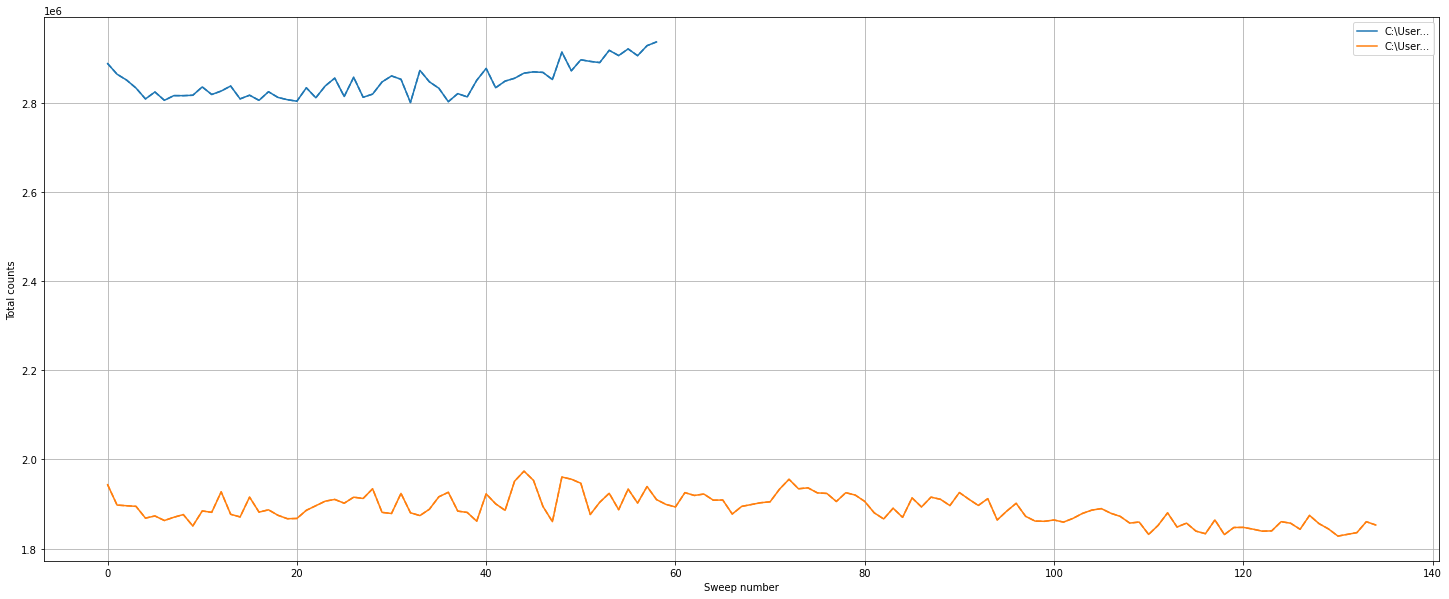

In [10]:
plt.figure(figsize=(25, 10))

range_selections = [slice(None, None, None) for _ in odmr_specs]
# range_selections[1] = slice(0, 70)
# range_selections[3] = odmr_specs[3].sum(axis=1) > 1.5e6

for spec, lbl, rng in zip(odmr_specs[swp_spcs], odmr_paths[swp_spcs], range_selections):
    sweep_counts = spec.sum(axis=1)
    sweep_ax = np.arange(len(sweep_counts))
    f, = plt.plot(sweep_counts, '--')
    plt.plot(sweep_ax[rng], sweep_counts[rng], f.get_color(), label=lbl[:7]+'...')

plt.legend()
plt.grid()
plt.xlabel("Sweep number")
plt.ylabel("Total counts")
plt.show()


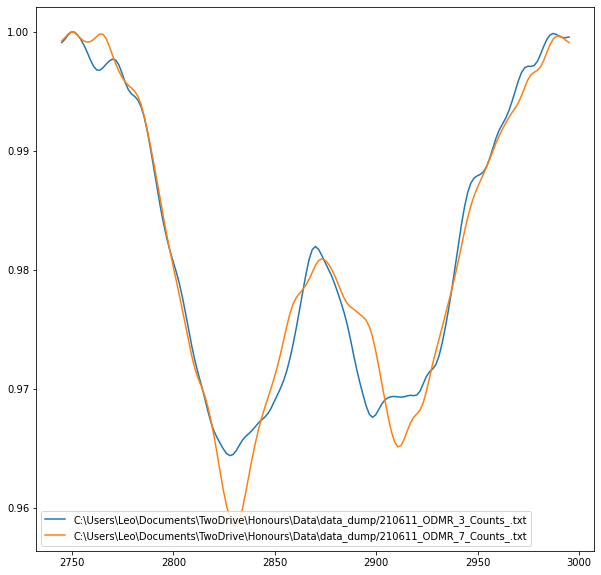

IndexError: list index out of range

In [11]:
plt.figure(figsize=(10, 10))

full_specs = []

for freq, spec, selection in zip(freq_axes, odmr_specs, range_selections):
    full_spec = spec[selection].sum(axis=0)
    # smooth
    full_spec = g_filter(full_spec, 2)
    full_spec /= max(full_spec)
    full_specs.append(full_spec)
    plt.plot(freq, full_spec)
plt.legend(odmr_paths)
plt.show()

good_specs = [0, 1, 2, 3, 5, 7]
full_good_specs = [full_specs[i] for i in good_specs]
good_freqs = [freq_axes[i] for i in good_specs]

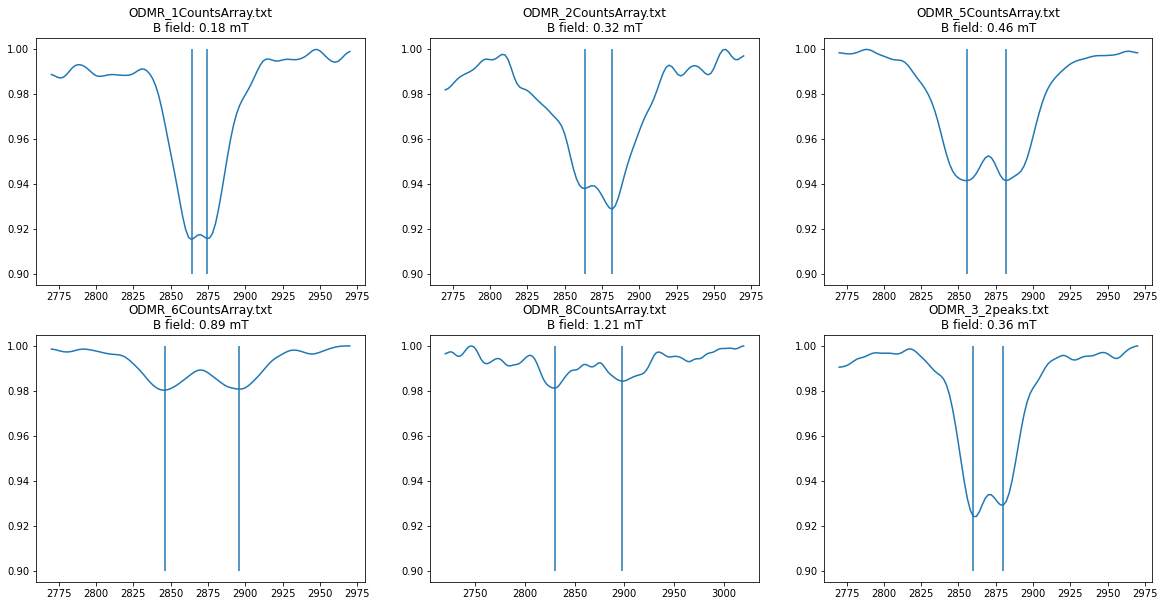

In [95]:
def find_peaks_sp(data, num_peaks):
    """ Find a specific number of peaks by finding the stationary points with the
    highest values in data. """
    diff = np.diff(data)
    # Find which values cross over zero
    prod = diff[1:] * diff[:-1]
    # prod will be negative where diff has crossed the x-axis
    sps = np.flatnonzero(prod < 0) + 1

    values = data[sps]
    pks = sps[values.argsort()[:num_peaks]]

    return pks

fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=2, ncols=3).flatten()
for freq, s, ax, i in zip(good_freqs, full_good_specs, axes, good_specs):
    pks = find_peaks_sp(s, 2)
    ax.plot(freq, s)
    freq_pks = freq[pks]
    ax.vlines(freq_pks, ymin=0.9, ymax=1)
    freq_sep = abs(np.diff(freq_pks))
    b_field = freq_sep[0] / 56
    ax.set_title(f"{odmr_paths[i]}\nB field: {b_field:.2f} mT")

plt.show()